In [30]:
#load modules
from ucimlrepo import fetch_ucirepo
from sklearn.feature_selection import f_classif, SelectKBest

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot
import warnings

warnings.filterwarnings('ignore')

In [31]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# description  of each feature abd check for missing values
heart_disease.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


In [32]:
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

# Fill missing values with median
X = X.fillna(X.median())
print(X)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
0        3  0.0   6.0  
1        2  3.0   3.0  
2        2  2.0

In [33]:
y.replace([2, 3, 4],[1, 1, 1], inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Feature 0: 17.098167
Feature 1: 19.658402
Feature 2: 40.865578
Feature 3: 6.820594
Feature 4: 4.504305
Feature 5: 0.023613
Feature 6: 7.536961
Feature 7: 37.312860
Feature 8: 50.631747
Feature 9: 53.221508
Feature 10: 28.887168
Feature 11: 71.313341
Feature 12: 73.289174


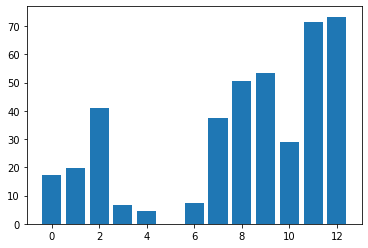

In [34]:
# feature selection - filter
##feature selection
def features_score(X_train, y_train):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    return fs

fs = features_score(X_train, y_train)

##show scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
##plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [35]:
# feature selection - filter
##base on the plot above, 4 features can be removed

##feature selection
fs = SelectKBest(score_func=f_classif, k=9)
# learn relationship from training data
X_train_fs = fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)

In [36]:
# Training logistic regression model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)

LogisticRegression(solver='liblinear')

In [37]:
# Use the model to make predictions on the testing data
y_pred = model.predict(X_test_fs)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(class_report)

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        29
           1       0.94      0.91      0.92        32

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61



In [38]:
# feature selection - wrapper
from sklearn.feature_selection import RFECV
from numpy import array 

model_warpper = LogisticRegression()

# Use RFE to select the top 10 features
rfe = RFECV(model_warpper, step=1, cv=5)
rfe.fit(X, y)

RFECV(cv=5, estimator=LogisticRegression())

In [40]:
feature_names = array(heart_disease.data.features.columns)

mask = rfe.get_support()
best_features = feature_names[mask]

print("Selected best: ", best_features.shape[0])
print(feature_names[mask]) 

Selected best:  11
['age' 'sex' 'cp' 'fbs' 'restecg' 'thalach' 'exang' 'oldpeak' 'slope' 'ca'
 'thal']


In [41]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [42]:
# Training logistic regression model
model_warpper = LogisticRegression(solver='liblinear')
model_warpper.fit(X_train_rfe, y_train)

LogisticRegression(solver='liblinear')

In [43]:
# Use the model to make predictions on the testing data
y_pred = model_warpper.predict(X_test_rfe)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(class_report)

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        29
           1       0.94      0.91      0.92        32

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61



In [45]:
# feature selection - embedded

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [46]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [47]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))
sel_.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [48]:
sel_feats = X_train.columns[(sel_.estimator_.coef_ != 0).ravel().tolist()]
sel_feats

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [49]:
X_train_selected = sel_.transform(scaler.transform(X_train))
X_test_selected = sel_.transform(scaler.transform(X_test))

In [50]:
# Training logistic regression model
model_emb = LogisticRegression(solver='liblinear')
model_emb.fit(X_train_selected, y_train)

LogisticRegression(solver='liblinear')

In [51]:
# Use the model to make predictions on the testing data
y_pred = model_emb.predict(X_test_selected)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(class_report)

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



In [52]:
log = LogisticRegression(solver='liblinear')
log.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [53]:
y_pred = log.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(class_report)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        29
           1       0.91      0.91      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

